## Importing libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Retrieval
from power.ml_ops.data import clean_pv_data, get_pv_data

# System
import os

# Deep Learning
#import tensorflow as tf

Manipulating temporal data is tricky, let's also import 📚 [`typing`](https://docs.python.org/3/library/typing.html) to check the types of variables we will be dealing with in our Python functions:

In [2]:
from typing import Dict, List, Tuple, Sequence

## Loading PV dataset

In [3]:
pv_raw_data = get_pv_data()
pv_df = clean_pv_data(pv_raw_data)
pv_df.head(3)

# data loaded
# data cleaned


,utc_time,local_time,electricity
0,1980-01-01 00:00:00+00:00,1980-01-01 01:00:00+01:00,0.0
1,1980-01-01 01:00:00+00:00,1980-01-01 02:00:00+01:00,0.0
2,1980-01-01 02:00:00+00:00,1980-01-01 03:00:00+01:00,0.0


In [4]:
pv_df.rename(columns={'electricity': 'pv_power'}, inplace=True)

In [5]:
pv_df =pv_df[['pv_power']]

In [6]:
pv_df.shape

(376944, 1)

In [9]:
pv_df.to_csv('D:\Documents\Learning\Data_Analytics\Le Wagon\pv_df.csv')

👆 In the preprocessed dataset, we have :
- 376k rows  (42 years of pv power data)
- 1 feature: <font color=green>**target**</font> (we will use the past values of the pv power as a feature)

This weather dataset is a DataFrame (dimension = 2) which is a single Time Series from the beginning of 1980 to the end 2022 with records every single hour.

* `df.shape = (n_timesteps, n_features) = (376944, 3)`

**Note:** For the rest of this notebook, we will ignore the timestamps columns and work only with pv power values.

In [7]:
TARGET = 'pv_power'
N_TARGETS = 1
N_FEATURES = 1

## Visualizing the time series

In [8]:
plot_cols = [TARGET]                        # a list with one column of the original df
plot_features = pv_df[plot_cols]            # creates new df Plot_features passing the filter [plot_cols]
plot_features.index = pv_df.index           # indices of plot_features will be the same as df


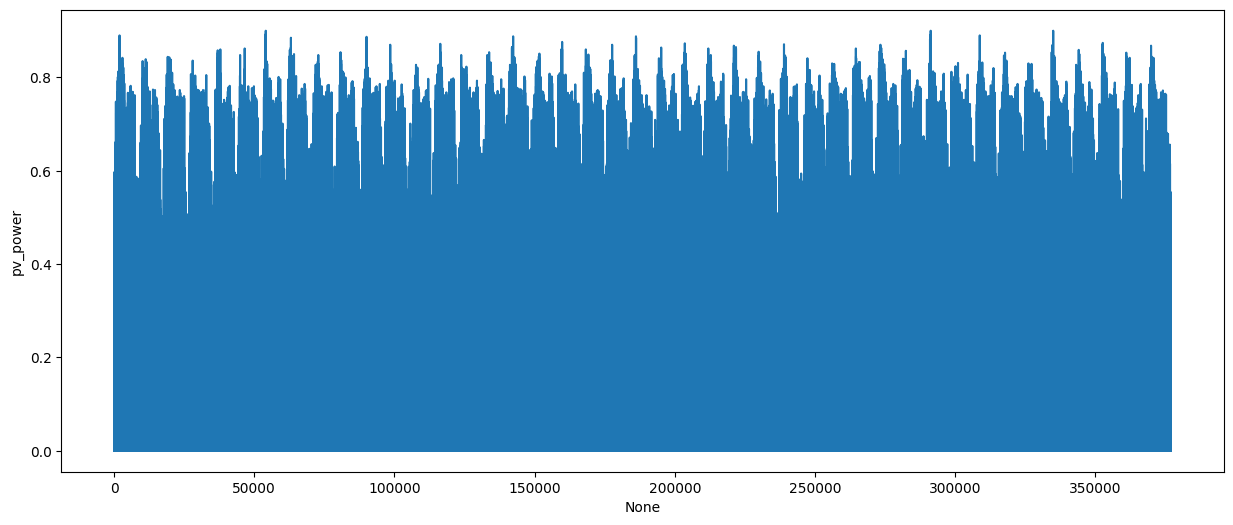

In [9]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=plot_features, x=plot_features.index, y='pv_power');

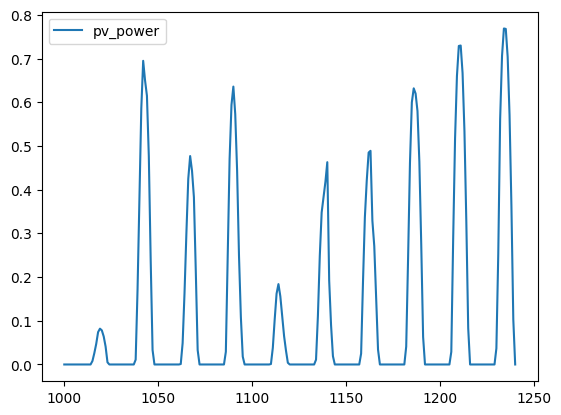

In [10]:
# slice(start, stop, step) returns a slice object that is used to slice any sequence.

zoomed_slice = slice(1000,1240) # 10 days worth of data

plot_features = pv_df.loc[zoomed_slice, plot_cols]
plot_features.plot();

## Preparing the pv dataset

* Step 1: Cross-Validation in Time Series [FOLDS]
* Step 2: Holdout method within each fold [TRAIN-TEST SPLIT]
* Step 3: Sampling SEQUENCES in both the train set and the test set

### Creating FOLDS for cross-validation

In [11]:
# Let's consider FOLDS with a length of 6 years       #
# (5 years will be used for train, 1 for test!)       #

FOLD_LENGTH = 24 * 365 * 6                            # 24 times a day * for 365 days (1 year) * for 6 years

# Let's consider FOLDS starting every year            #

FOLD_STRIDE = 24 * 365                                # 24 times a day for 365 days (1 year)

# Let's consider a train-test-split ratio of 5/6      #

TRAIN_TEST_RATIO = 0.83                               # 5 years train, 1 year test

In [12]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    for idx in range(0, len(df), fold_stride):
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (6 years), all the columns
        folds.append(fold)                        # append the 6 year fold to folds
    return folds

In [13]:
folds = get_folds(pv_df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The get_fold function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The get_fold function generated 38 folds.
Each fold has a shape equal to (52560, 1).


In [14]:
fold_0 = folds[0]

### Train/Test Split

We want to split this fold **chronologically** into:

- a train dataframe
- a test dataframe

that will contain all the data we need to be able to sample many `(X_i, y_i)` pairs in each dataframe in a next step! 
The `INPUT_LENGTH` of each `X_i` is going to be equal to 2 weeks.

In [15]:
INPUT_LENGTH = 24 * 14       # records every hour (24 hours) x 14 days (two weeks) = 336

Function `train_test_split` below:
- <i>(input)</i> given a `fold` (like above), a `train_test_ratio` (e.g 0.8) and an `input_length` (fixed)
- <i>(output)</i> a tuple of (`fold_train`, `fold_test`) dataframes


**NOTE:** 

This following functions will focus on one fold only. Later, when we are done with the splitting and sequencing of one fold, we will call both of the them inside a function and will loop over all folds.

In [16]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))    # 83% of the fold for train
    fold_train = fold.iloc[0:last_train_idx, :]             # 1st until last row of train set, all columns

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length          # last row of train set - 2 weeks --> test set starts 2 weeks
                                                            # before train set ends --> overlap (not a problem with X)
    fold_test = fold.iloc[first_test_idx:, :]               # 1st until last row of test set, all columns

    return (fold_train, fold_test)

Now we can try it to see its performance:

In [17]:
(fold_train_0, fold_test_0) = train_test_split(fold_0, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [18]:
fold_train_0

,pv_power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
...,...
43620,0.018
43621,0.007
43622,0.000
43623,0.000


### Create (X, y) sequences

Now that we have splitted our fold into a **train** set and a **test** set, it is time to:
- sample lots of sequences $(X_i, y_i)$ on which the model will be **trained**
- sample lots of sequences $(X_i, y_i)$ on which the model will be **evaluated**

We are now dealing with **3D arrays** instead of **2D DataFrames** time-series:
* `X_train.shape = (n_samples_train, input_length, n_features)`
* `y_train.shape = (n_samples_train, output_length, n_targets)`

In [19]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days = {int(INPUT_LENGTH/24/7)} weeks')

N_FEATURES = 1
INPUT_LENGTH = 336 timesteps = 14 days = 2 weeks


**X** is the **input** of our model. 
- It contains one single feature: the past values of the **target**
- Each sequence has a length equal to $336$ timesteps (=$2$ weeks)

In [20]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

OUTPUT_LENGTH = 24
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 24


**y** is the **target** that we want to predic:
- It is the values at the next 24 timestep (= 24 hours later)

To create these SEQUENCES within the **train** set and the **test** set, we can scan a fold chronologically and create all the possible pairs $(X_i, y_i)$.

The following function will scan a fold chronologically based on:
  - an `input_length` (`INPUT_LENGTH = 24 * 14`, i.e. two weeks) 
  - and a `sequence_stride`

Let's scan the fold with a temporal stride of only 1 hour (the minimum one):

In [22]:
SEQUENCE_STRIDE = 24

In [23]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
      using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]] # index + length of sequence until index + length of seq. + length of target
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [24]:
print("FOLD_LENGTH")
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/24)} days") # 24 records per day
print(f"= {int(FOLD_LENGTH/24/7)} weeks")

FOLD_LENGTH
= 52560 timesteps
= 2190 days
= 312 weeks


In [25]:
X_train_0, y_train_0 = get_X_y_strides(fold_train_0, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_0, y_test_0 = get_X_y_strides(fold_test_0, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_0.shape)
print(y_train_0.shape)

(1803, 336, 1)
(1803, 24, 1)


## Modeling

The Mean Absolute Error seems to be a reasonable metrics to evaluate a model's capability to predict the temperature because an error of 4 degrees is simply twice as bad as an error of 2 degrees:

$$ MAE = \frac{1}{n_{samples}} \times \sum_{i = 1}^{n_{samples}} |y_{true}^{(i)} - y_{pred}^{(i)}|$$

### RNN: the `LSTM`

- Creating a function `init_model` which builds and compiles a simple RNN with an LSTM layer
- We will also normalize our data with a [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [26]:
X_train_0.shape

(1803, 336, 1)

In [27]:
y_train_0.shape

(1803, 24, 1)

In [28]:
from tensorflow.keras import models, layers, optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):


    # 0 - Normalization
    # ======================
    normalizer = Normalization()   # Instantiate a normalizer (Standard Scaler)
    normalizer.adapt(X_train)      # trains the normalizer

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

2024-03-05 19:05:32.402818: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 19:05:32.906990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:05:32.907073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:05:33.058570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 19:05:33.371463: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 19:05:33.374170: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [29]:
model = init_model(X_train_0, y_train_0)
model.summary()

2024-03-05 19:05:46.577695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 19:05:46.579399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

Function `plot_history` to visualize the training of RNN over epochs. This function shows both the evolution of the loss function (MSE) and metrics (MAE).

In [30]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

`fit_model()` method:
    - <i>(input)</i> given `model`
    - <i>(output)</i> returns the fitted model through a tuple `(model, history)` 
- Then:
    - Initializing an RNN model with the `init_model` function that
    - **Trains** the model
    - **Evaluates** it on the test set

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model, verbose=1): # -> Tuple[model, dict]:  # : tf.keras.Model

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,            # the order matters!!!
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history                           # returns a tuple: (model, dict(history))

In [37]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train_0, y_train_0)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [38]:
plot_history(history);

NameError: name 'history' is not defined

In [ ]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test_0, y_test_0)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} kW")

### A Baseline Model to compare our LSTM with!

This baseline model is to predict the **last seen values** for the future value(s) you want to forecast

The following method `init_baseline` that initializes and compiles a baseline model in a similar way to the LSTM.

- The baseline should be as a [Keras Lambda Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)
- It should not even need a `fit` because it should have 0 trainable params
- Then, we compute the MAE for this FOLD and compare it with the MAE we obtained on the test set after training the LSTM 

In [39]:
from tensorflow.keras.layers import Lambda              # Wraps arbitrary expressions as a Layer object

def init_baseline():

    model = models.Sequential()
    # a layer to take the last value of the sequence and output it
    model.add(layers.Lambda(lambda x: x[:,-24:-1,0,None]))  # all sequences, last day, 1 feature (pv_power)


    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [ ]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test_0, y_test_0)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} Celsius degrees")

In [ ]:
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} kW")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

### Cross-Validation

* We just did (train/test split) and (get_X_y) only **for one single FOLD**. 
* ***If we want to ensure the robustness of a model, we need to cross-validate the model on ALL the folds!***

In [41]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}')
print(f'N_TARGETS = {N_TARGETS}')
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 1
N_TARGETS = 1

FOLD_LENGTH = 52560
FOLD_STRIDE = 8760
TRAIN_TEST_RATIO = 0.83

INPUT_LENGTH = 336
OUTPUT_LENGTH = 24


**Cross validating our baseline and RNN model in a for-loop!**

Re-using our previously defined methods
- `get_folds`
- `train_test_split`
- `get_X_y`
- `init_model`
- `init_baseline`

In [42]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(pv_df, FOLD_LENGTH, FOLD_STRIDE)  # function we coded to get the folds

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH) # function we coded to split train/test

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]   # evaluating baseline model (metric)
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 5,
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [ ]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")